In [1]:
# https://siboehm.com/articles/19/normalizing-flow-network
# https://github.com/karpathy/pytorch-normalizing-flows
# https://arxiv.org/pdf/1908.09257.pdf

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as stats
from sklearn import datasets

### Normalizing Flows (2D)

We know that we can apply transformations with certain contraints (differentiable and invertible) to a know distribution and get new distributions from which we can sample and compute its likelihood. In this notebook we will explore some of this functions known as Normalizing Flows (NF).

We will with the following synthetic dataset

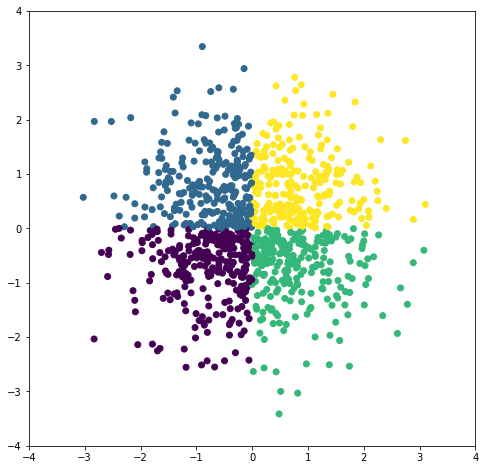

In [35]:
X = np.random.multivariate_normal(mean = [0, 0], cov = [[1, 0], [0, 1]], 
                                  size = 1000)
def annotate(x):
    if(x[0] < 0 and x[1] < 0):
        return 1
    elif(x[0] < 0 and x[1] > 0):
        return 2
    elif(x[0] > 0 and x[1] < 0):
        return 3
    else:
        return 4
    
Y = [annotate(x) for x in X]

plt.figure(figsize = (8,8))
plt.scatter(X[:,0], X[:,1], c = Y)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

#### Affine Flows

$a, b \in \mathbb{R}^{d} \quad f(x)=e^{a}\odot x + b \quad f^{-1}(z)=$

In [69]:
def AffineFlow_forward(x, a, b):
        return np.exp(a) * x + b
    
def AffineFlow_backward(z, a, b):
        return (z - b) * np.exp(-a)

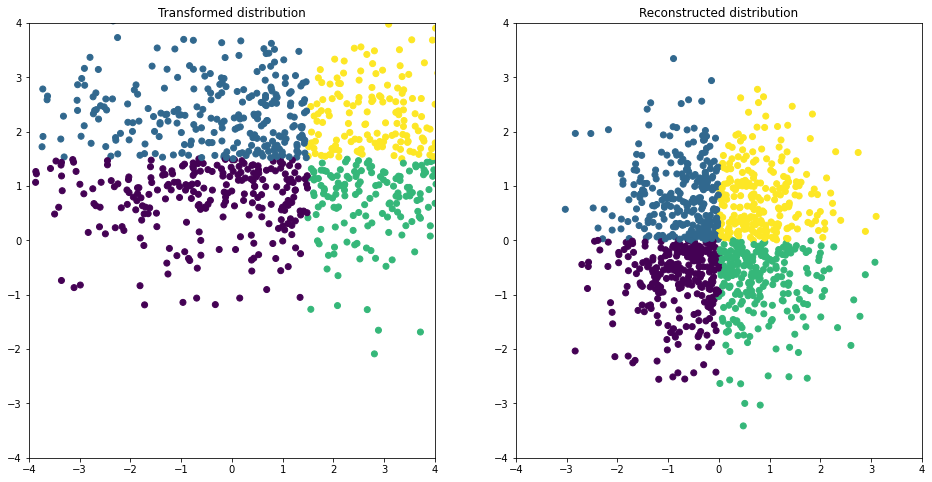

In [85]:
a = np.array([1, 0.05])
b = np.array([1.5, 1.5])

Xt = AffineFlow_forward(X, a = a, b = b)
Xr = AffineFlow_backward(Xt, a = a, b = b)

fig, axs = plt.subplots(1, 2, figsize = (16, 8))
axs[0].scatter(Xt[:,0], Xt[:,1], c = Y)
axs[1].scatter(Xr[:,0], Xr[:,1], c = Y)

axs[0].set_xlim(-4, 4)
axs[0].set_ylim(-4, 4)
axs[1].set_xlim(-4, 4)
axs[1].set_ylim(-4, 4)

axs[0].title.set_text('Transformed distribution')
axs[1].title.set_text('Reconstructed distribution')

plt.show()

In [88]:
stats.multivariate_normal.pdf(X[0],
                              mean = [0, 0], cov = [[1, 0], [0, 1]])

0.05758645817273348

In [ ]:
# Compute prob on transformed distribution

#### Affine Flows